In [1]:
import seaborn as sns
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
from dateutil.parser import parse


from utils import *
from datetime import datetime

In [3]:
#raw_df = pd.read_csv('Consumer_Complaints_Data_-_Unwanted_Calls.csv')
raw_df = pd.read_csv('data/FCC_reported_calls.csv')

In [4]:
raw_df.head()


,Ticket ID,Date of Issue,Time of Issue,Form,Method,Issue,Caller ID Number,Type of Call or Messge,Advertiser Business Number,State,Zip,Location (Center point of the Zip Code)
0,100358,01/26/2015,8:35 am,Phone,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,617-681-5500,Prerecorded Voice,NaN,WA,98115,"WA 98115\n(47.685291, -122.297534)"
1,157640,03/02/2015,2:16 p.m.,Phone,Wired,Telemarketing (including do not call and spoof...,NaN,Prerecorded Voice,NaN,CO,80138,"CO 80138\n(39.518092, -104.688882)"
2,104244,01/28/2015,11:00 AM,Phone,Wireless (cell phone/other mobile device),Robocalls,415-964-2785,Prerecorded Voice,NaN,FL,33139,"FL 33139\n(25.783695, -80.141739)"
3,153519,02/27/2015,11:31 AM,Phone,Wired,Robocalls,404-381-1115,Prerecorded Voice,NaN,VA,22182,"VA 22182\n(38.932908, -77.267432)"
4,145971,02/23/2015,3:24 P.M.,Phone,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,203-204-2992,Live Voice,NaN,PA,17403,"PA 17403\n(39.935487, -76.710483)"


##### Data cleanup

Columns to remove: Form, Method, Advertiser Business Number, Location, Ticket ID?
Columns to modify: format 'Time of Issue' regex for, 'Method' & 'Issue' remove parenthesis and contents
Remove rows based on NaN on Zip column

In [5]:
# Drop unused columns
fcc_df = raw_df.drop(columns=['Form','Advertiser Business Number'])

# Create a single date+time column
fcc_df['DateTime'] = fcc_df[['Date of Issue','Time of Issue']].apply(lambda row: parse_date(row.values[0],row.values[1]), axis=1)
fcc_df.drop(columns=['Date of Issue','Time of Issue'],inplace=True)

# Split up DateTime column
month, day, year, hour, minute = zip(*[(None, None, None, None, None) if dt is None else (dt.month, dt.day, dt.year, dt.hour, dt.minute) for dt in fcc_df['DateTime']])
fcc_df = fcc_df.assign(Month = month, Day = day, Year = year, Hour = hour, Minute = minute)

# Simply string entries for Method and Issue
fcc_df['Method'] = fcc_df['Method'].apply(func=remove_parenthesis)
fcc_df['Issue'] = fcc_df['Issue'].apply(func=remove_parenthesis)

##### Data cleanup
Columns to modify: extract latitude and longitude data from column 'Location (Center point of the Zip Code)'

In [38]:
fcc_df_location =  fcc_df['Location (Center point of the Zip Code)'].str.extract('.*\((.*)\,(.*)\).*')
fcc_df_location.columns = ['Latitude', 'Longitude']
fcc_df['Latitude'] = (fcc_df_location['Latitude'])
fcc_df['Longitude'] = (fcc_df_location['Longitude'])
fcc_df['Location'] =  fcc_df['Location (Center point of the Zip Code)'].str.extract('.*\((.*\,.*)\).*')[0]
fcc_df = fcc_df.drop(columns=['Location (Center point of the Zip Code)'])

In [6]:
fcc_df.head()

,Ticket ID,Date of Issue,Time of Issue,Method,Issue,Caller ID Number,Type of Call or Messge,State,Zip,Latitude,Longitude,Location
0,100358,01/26/2015,8:35 am,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,617-681-5500,Prerecorded Voice,WA,98115,47.685291,-122.297534,"47.685291, -122.297534"
1,157640,03/02/2015,2:16 p.m.,Wired,Telemarketing (including do not call and spoof...,NaN,Prerecorded Voice,CO,80138,39.518092,-104.688882,"39.518092, -104.688882"
2,104244,01/28/2015,11:00 AM,Wireless (cell phone/other mobile device),Robocalls,415-964-2785,Prerecorded Voice,FL,33139,25.783695,-80.141739,"25.783695, -80.141739"
3,153519,02/27/2015,11:31 AM,Wired,Robocalls,404-381-1115,Prerecorded Voice,VA,22182,38.932908,-77.267432,"38.932908, -77.267432"
4,145971,02/23/2015,3:24 P.M.,Wireless (cell phone/other mobile device),Telemarketing (including do not call and spoof...,203-204-2992,Live Voice,PA,17403,39.935487,-76.710483,"39.935487, -76.710483"


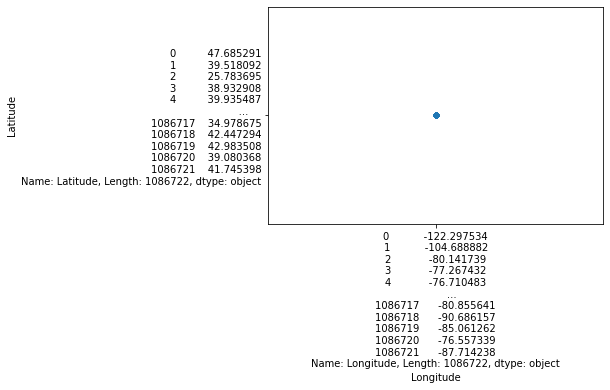

In [39]:
import matplotlib.pyplot as plt
fcc_df.plot(kind="scatter", x='Longitude', y='Latitude', alpha=0.2)
plt.show()


In [44]:
fcc_df.plot(kind="scatter", x="Longitude", y="Latitude",
    s=fcc_df['Zip'], label="Zip",
    c="Ticket ID", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
plt.legend()
plt.show()

In [45]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

import pandas as pd
coords = pd.concat([fcc_df['Latitude'], fcc_df['Longitude'], fcc_df['Zip']], axis=1)
coords = coords.sample(frac=0.1, replace=True)
cases = []
colors = ['rgb(239,243,255)','rgb(189,215,231)','rgb(107,174,214)','rgb(33,113,181)']
months = {6:'June',7:'July',8:'Aug',9:'Sept'}

for i in range(6,10)[::-1]:
    cases.append(go.Scattergeo(
        lon = coords['Longitude'],
        lat = coords['Latitude'],
        marker = dict(
            size = coords['Zip'],
            color = 'colors[i-6]',
            opacity = .4,
            line = dict(width = 0)
        ),
    ) )

cases[0]['mode'] = 'markers'

layout = go.Layout(
    title = 'Hey look! It\'s a scatter plot on a map!',
    geo = dict(
        resolution = 100,
        scope = 'usa',
        showframe = False,
        showcoastlines = True,
        showland = True,
        landcolor = "rgb(229, 229, 229)",
        countrycolor = "rgb(255, 255, 255)" ,
        coastlinecolor = "rgb(255, 255, 255)",
        projection = dict(
            type = 'Mercator'
        ),
        lonaxis = dict( range= [ -124.0, -113.0 ] ),
        lataxis = dict( range= [ 32.0, 43.0 ] ),
        
    ),
    legend = dict(
           traceorder = 'reversed'
    )
)


fig = go.Figure(layout=layout, data=cases)
plotly.offline.iplot(fig, validate=False, filename='iantest')

ModuleNotFoundError: No module named 'plotly'

In [47]:
fcc_zipcode_counts = fcc_df[['State', 'Latitude', 'Longitude', 'Location']]
fcc_zipcode_counts = fcc_zipcode_counts.groupby(['State', 'Latitude', 'Longitude', 'Location']).size().reset_index().rename(columns={0:'count'})
fcc_zipcode_counts.head(20)

,State,Latitude,Longitude,Location,count
0,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"19.930848, -155.813845",1
1,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"26.346907, -80.158593",1
2,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"28.929091, -81.928009",1
3,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"29.409887, -95.248871",1
4,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"29.582056, -81.249008",1
5,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"29.894693, -95.185676",1
6,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"29.951698, -90.103877",1
7,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"30.402779, -88.965616",1
8,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"30.408259, -87.552173",1
9,AK,0 47.685291\n1 39.518092\n2 ...,0 -122.297534\n1 -104.6888...,"30.546381, -84.140352",1


<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

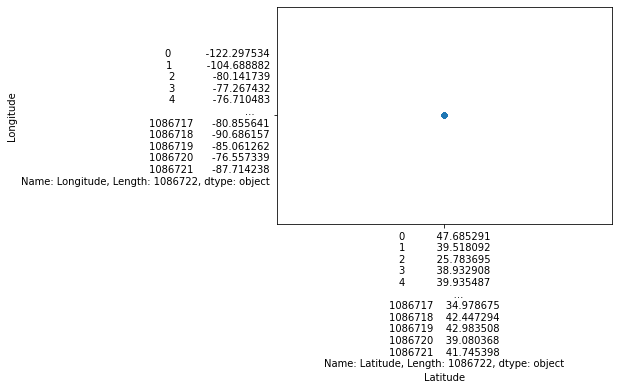

In [50]:
fcc_zipcode_counts.plot.scatter(x='Latitude', y='Longitude')

<AxesSubplot:xlabel='count', ylabel='State'>

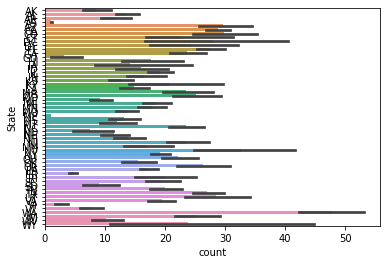

In [51]:
sns.barplot(x='count', y='State', data=fcc_zipcode_counts)

In [72]:
import pandas as pd
import numpy as np
import folium 
import matplotlib.pyplot as plt
region_map = folium.Map(location = [19.930848, -155.813845],zoom_start = 10) #AK
region_map

In [66]:
fcc_zipcode_counts['Location'][1]

'26.346907, -80.158593'

In [73]:
#i need help how to change the location in to floating coordinates to visualize a map with specified zipcode.
#and to plot the zipcode matching to the states
#i'm struggling to map the desnsity zipcode, Latitude, longitude to visualize
#i tried in different way to map by installing some library packages

In [ ]:
#to use modeling such kind logistic regression help us estimate a probability
#of falling into a certain level of income range. inorder to get accuracy in
#our prediction we need two features 
#the first features from fcc datasets to based on the location of unwanted 
#calls received and on the second feature from the irs we retrieve the
#range of income, i believe since both features are independent we need
#to check whether it is correlate or not by using scattered plot 
#after that we can apply logistic regression model to predict how many 
#number unwanted calls can receive with in the range of income 